<a href="https://colab.research.google.com/github/ptran1203/gan_project/blob/master/try_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content

/content


In [2]:
%tensorflow_version 1.x
from google.colab import drive, output
drive.mount('/content/drive')

!rm -rf '/content/gan_project'
!git clone https://github.com/ptran1203/gan_project
!pip install git+https://www.github.com/keras-team/keras-contrib.git
output.clear()

In [3]:
cd gan_project

/content/gan_project


In [4]:

# K.common.set_image_dim_ordering('tf')
BASE_DIR = '/content/drive/My Drive/bagan'
DS_DIR = '/content/drive/My Drive/bagan/dataset/chest_xray'
DS_SAVE_DIR = '/content/drive/My Drive/bagan/dataset/save'
gratio_mode = 'uniform'
dratio_mode = 'uniform'

from new_gan import *
from batch_gen import *
from utils import *
from tensorflow.keras.layers import LayerNormalization

def create_dir_if_any(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

class Bagan(BalancingGAN):
    attribute_loss_weight = 0.1
    def interval_process(self, epoch):
        if epoch % 400 == 0 and epoch > 0:
            output.clear()
    
    def get_pair_features(self, image_batch): return 0,0
    # def backup_point(self, epoch): return
    def evaluate_d(self, test_x, test_y): return
    def evaluate_g(self, test_x, test_y): return

    def build_features_from_d_model(self):
        image = Input(shape=(self.resolution, self.resolution, self.channels))
        print(self.discriminator.layers)
        model_output = self.discriminator.layers[-3](image)
        
        self.features_from_d_model = Model(
            inputs = image,
            output = model_output,
            name = 'Feature_matching'
        )


class BatchGen(BatchGenerator):
    # to_train_classes = list(range(0, 60))
    to_train_classes = INVERT_CATEGORIES_MAP[:3]
    to_test_classes = list(range(81, 86))


is_test = 0
## Test batch GEN
if is_test:
    bg = BatchGen(BatchGen.TRAIN, 64, 'multi_chest', 64)
    labels = np.array([0, 0, 1, 1, 2, 2, 3 ,1])
    samples = bg.ramdom_kshot_images(4, labels)
    print(samples.shape)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


load data from /content/drive/My Drive/bagan/dataset/multi_chest/imgs_labels_64.pkl successfully
3000 3000
load data from /content/drive/My Drive/bagan/dataset/multi_chest/imgs_labels_64.pkl successfully
9679 9679
input data loaded...
img shape (64, 64, 1)
Class counters:  [1000, 1000, 1000]

=================== GAN Setting ==================

INFO: - Dataset: multi_chest
INFO: - Num of classes: 3
INFO: - Generator type: encode_decode
INFO: - Self-Attention: False
INFO: - K-shot: 2
INFO: - Adverasial loss: hinge
INFO: - Normalization: Instance norm
INFO: - Use feature normaliztion: True
- Advance losses:  {'l2_feat': 0.7, 'recon': 0.1}


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Latent model modified at:  2020-06-24 04:28:39
[<keras.engine.input_layer.InputLayer object at 0x7fa6f0395668>, <keras.layers.convolutional.Conv2D object at 0x7fa6f0395e80>, <keras.layers.advanced_activations.LeakyReLU object at 0x7fa6f0395f98>, <keras.layers.core.Dropout

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="Feature_matching", outputs=Tensor("dr...)`


INFO: Use Batch norm for FeatureNorm layer
INFO: Use Batch norm for FeatureNorm layer
INFO: Use Batch norm for FeatureNorm layer
INFO: Use Batch norm for FeatureNorm layer
INFO: Use Batch norm for FeatureNorm layer
INFO: Use Batch norm for FeatureNorm layer
['loss', 'discriminator_loss', 'VGG16_embbeder_loss', 'discriminator_accuracy', 'VGG16_embbeder_accuracy']
['loss', 'accuracy']
init gan
GAN weight initialized, train from epoch  0
Reload error, restart from scratch  You are trying to load a weight file containing 10 layers into a model with 19 layers.
gan initialized, start_e:  0



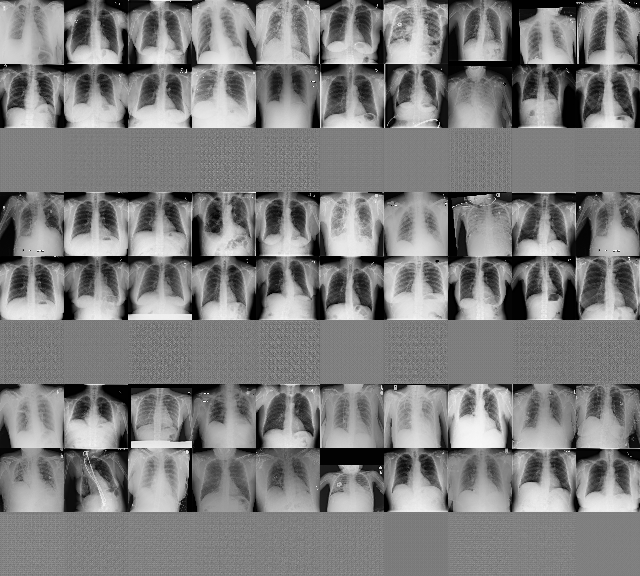

GAN train epoch: 1/400000


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


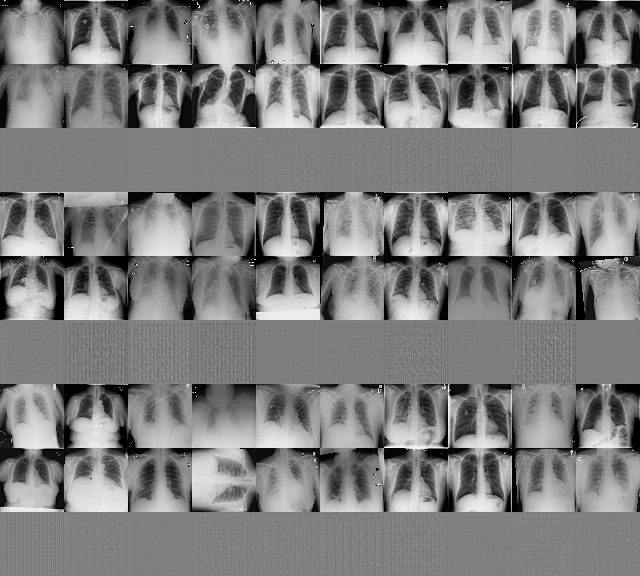

/content/gan_project/utils.py:208: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


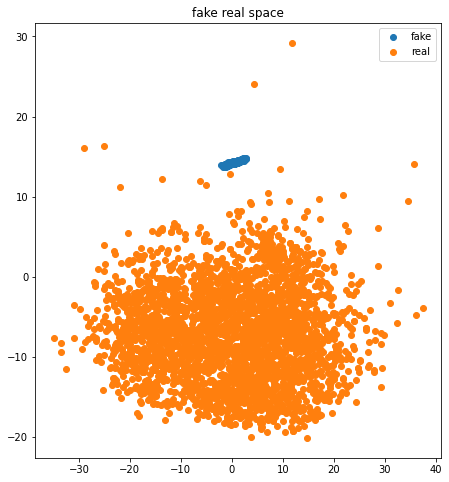

/content/gan_project/utils.py:208: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


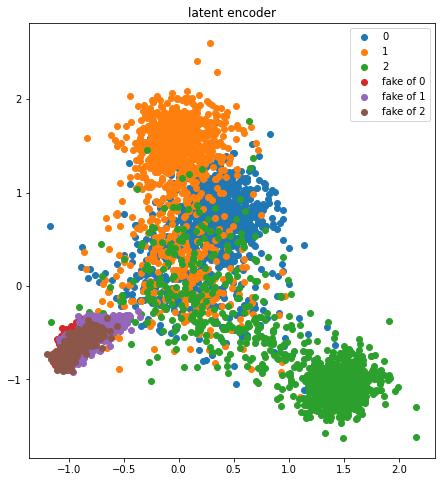

- D_loss 0.3714004569363011, G_adv_loss 1.1582618951797485 G_mse_loss 0.04500114545226097 - 0:01:00.438334
GAN train epoch: 2/400000


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


- D_loss 0.008171426942167074, G_adv_loss 1.9132550954818726 G_mse_loss 0.04242933914065361 - 0:00:29.000885
GAN train epoch: 3/400000
- D_loss 0.003582096010770487, G_adv_loss 1.9558618068695068 G_mse_loss 0.04044974967837334 - 0:00:28.997791
GAN train epoch: 4/400000
- D_loss 0.11399228189585973, G_adv_loss 2.077770233154297 G_mse_loss 0.039112795144319534 - 0:00:29.059281
GAN train epoch: 5/400000
- D_loss 0.010317125226087544, G_adv_loss 2.2287116050720215 G_mse_loss 0.037383824586868286 - 0:00:29.024106
GAN train epoch: 6/400000
- D_loss 0.31503362587207684, G_adv_loss 2.8340532779693604 G_mse_loss 0.03604959324002266 - 0:00:29.022339
GAN train epoch: 7/400000
- D_loss 0.3494079430769805, G_adv_loss 3.1269686222076416 G_mse_loss 0.0348077192902565 - 0:00:29.033492
GAN train epoch: 8/400000
- D_loss 0.48427409792075987, G_adv_loss 2.005380392074585 G_mse_loss 0.033365629613399506 - 0:00:29.017560
GAN train epoch: 9/400000
- D_loss 0.06201331212144831, G_adv_loss 3.802278995513916 G

In [ ]:
gan_epochs  = 400000
# Discriminator learning rate
adam_lr = 0.0002
# Generator learning rate
g_lr = 0.00005
batch_size = 128
# dataset_name should be "flowers", "chest", "multi_chest"
# "chest" is binary classification, "multi_chest" using chest-xray14 dataset
dataset_name = 'multi_chest'
latent_size = 128
# Use resnet architecture for Generator
resnet = False
# Use self-attention mechanism
attention = False
np.random.seed(0)
# Image resoulution
rst = 64
# Number of images used to generate feature for Generator should be 2 - 5
k_shot = 2
sampling = 'normal'
# triplet, recon, l2_feat
advance_losses = {
    'l2_feat': 0.7,
    'recon': 0.1,
    }
"""
batch: batch norm
in: instance norm
fn: feature norm
D-fn: use feature norm for Discriminator
"""
norm = 'fn-in-bn'
# Adversarial loss type
loss_type = 'hinge'

is_prune = False

# prune = [700] * 11 if is_prune else None
prune = [0,2500] if is_prune else None

res_dir = BASE_DIR + '/result/model_{}_{}_v2'.format(dataset_name,rst)
create_dir_if_any(res_dir)

bg_train_full = BatchGen(BatchGen.TRAIN, batch_size, dataset_name, rst,prune_classes=prune)

bg_test = BatchGen(BatchGen.TEST, batch_size, dataset_name, rst)

channels = bg_train_full.dataset_x[0].shape[-1]

print("input data loaded...")

shape = bg_train_full.dataset_x[0].shape

print('img shape', shape)
classes = bg_train_full.get_label_table()
# Initialize statistics information
gan_train_losses = defaultdict(list)
gan_test_losses = defaultdict(list)

img_samples = defaultdict(list)

# For all possible minority classes.
target_classes = np.array(range(len(classes)))


print('Class counters: ', bg_train_full.per_class_count)

# Train GAN to balance the data
gan = Bagan(
    target_classes, loss_type,
    adam_lr=adam_lr, latent_size=latent_size,res_dir=res_dir,image_shape=shape,
    g_lr = g_lr,
    norm = norm,
    resnet=resnet,
    dataset=dataset_name,
    attention=attention,
    k_shot=k_shot,
    sampling=sampling,
    advance_losses=advance_losses,
)
print(gan.combined.metrics_names)
print(gan.discriminator_fake.metrics_names)

# plot_model(gan.generator, to_file=BASE_DIR + '/gen.png')
# gan.init_gan()
gan.train(bg_train_full, bg_test, epochs=gan_epochs)


In [ ]:
self = gan
bg_train = bg_train_full
real_label = -np.ones((16, 1))
for _, label_batch in bg_train_full.next_batch():
    k_shot_batch = bg_train.ramdom_kshot_images(self.k_shot, label_batch)
    f = self.generate_latent(label_batch)
    negative_samples = bg_train.get_samples_by_labels(bg_train.other_labels(label_batch))
    real_attribute = self.latent_codes(k_shot_batch)
    print(k_shot_batch.shape, negative_samples.shape,real_label.shape,real_attribute.shape)
    print(f.shape)
    [loss, d_loss, l_loss, *rest] = self.combined.train_on_batch(
        [k_shot_batch, negative_samples, f],
        [real_label, real_attribute],
    )


Counter(bg_train_full.dataset_y)

In [ ]:
self.generator.summary()

In [ ]:
gan.backup_point(5)

In [ ]:
bg = bg_train_full
x, y = bg.dataset_x, bg.dataset_y

test_size = 500

class_1 = bg.ramdom_kshot_images(k_shot, np.full(test_size, 0))
class_2 = bg.ramdom_kshot_images(k_shot, np.full(test_size, 1))

fake_1 = gan.generator.predict([class_1,
                                gan.generate_latent(range(test_size))])

fake_2 = gan.generator.predict([class_2,
                                gan.generate_latent(range(test_size))])

x = np.concatenate([x, fake_1, fake_2])
y = np.concatenate([y, np.full((test_size,), 'Pneu'),  np.full((test_size,), 'Normal')])
# utils.plot_data_space(x, y, gan.features_from_d_model, 'latent encoder')
# utils.plot_data_space(x, y, gan.latent_encoder, 'latent encoder')

print(np.mean(np.abs(gan.latent_code(triple_channels(fake_2)) - gan.latent_codes(class_1))))
print(np.mean(np.abs(gan.latent_code(triple_channels(fake_1)) - gan.latent_codes(class_2))))

show_samples(class_1[:,0,][:10])
show_samples(fake_1[:10])
show_samples(class_2[:,0,][:10])
show_samples(fake_2[:10])

In [ ]:
def generate_images_for_class(self, bg, classid, samples=10):
    latent = self.generate_latent([classid] * samples)
    images = bg.ramdom_kshot_images(self.k_shot,
                                    np.full(samples, classid))
    generated_images = self.generator.predict([images, latent])
    return generated_images

def classify_by_metric(self, bg, images, metric='l2'):
    supports = [bg.get_samples_for_class(i, 1) \
                    for i in self.classes]
    sp_vectors = [self.latent_encoder.predict(triple_channels(s_img)) \
                    for s_img in supports]
    vector = self.latent_encoder.predict(triple_channels(images))
    distances = [np.mean(np.square(vector - svec)) for svec in sp_vectors]
    pred = np.argmin(np.array(distances))
    return pred
 

test = 1
same_img = False
show = False
test_size = 10
bg = bg_train_full if not test else bg_test

imgs = generate_images_for_class(gan, bg, 0)
# show_samples(imgs)

idx =np.random.randint(0, bg.dataset_y.shape[0] - 1)
classify_by_metric(gan, bg, bg.dataset_x[idx:idx+1])
print("true label: ", bg.dataset_y[idx])


In [ ]:
bg = bg_test
size = 20
x = bg.get_samples_for_class(0, size)
y = bg.get_samples_for_class(1, size)
images = x[0:1]
labels  = []
latent = np.random.normal(0, 1, 128).reshape(1, 128)

def generate_for_class(bg, size=1000):
    random = np.arange(bg.dataset_y.shape[0])
    np.random.shuffle(random)
    labels = bg.dataset_y[random][:size]
    latent = gan.generate_latent(labels)
    generated = gan.generator.predict([bg.ramdom_kshot_images(gan.k_shot, labels), latent])
    return generated, labels

images, labels = generate_for_class(bg_train_full, 5000)

res = (images * 127.5 + 127.5, np.array(labels))


In [ ]:
show_samples(images[:10])
print(labels[:10])
print(Counter(labels))
pickle_save(res, '/content/drive/My Drive/bagan/dataset/multi_chest/imgs_train_gen_v2.pkl')